In [ ]:
!nvidia-smi

Fri Aug 19 03:26:10 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    25W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
%%time
!pip install torchtext==0.11.0 -q 
!pip install torch==1.10.1+cu111 torchvision==0.11.2+cu111 torchaudio==0.10.1 -f https://download.pytorch.org/whl/torch_stable.html -q
!pip install timm albumentations opencv-python -q
!pip install pytorch-lightning==1.6.5 -q
!pip install wandb python-box -q

!git clone https://github.com/NVIDIA/apex
%cd apex
!pip install -v --disable-pip-version-check --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ./
%cd /content

     |████████████████████████████████| 8.0 MB 8.7 MB/s 
     |██████████████████████████████▎ | 834.1 MB 1.1 MB/s eta 0:00:43tcmalloc: large alloc 1147494400 bytes == 0x39320000 @  0x7f9357760615 0x592b76 0x4df71e 0x59afff 0x515655 0x549576 0x593fce 0x548ae9 0x51566f 0x549576 0x593fce 0x548ae9 0x5127f1 0x598e3b 0x511f68 0x598e3b 0x511f68 0x598e3b 0x511f68 0x4bc98a 0x532e76 0x594b72 0x515600 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576 0x593fce 0x5118f8 0x593dd7
     |████████████████████████████████| 881.9 MB 14 kB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.13.1+cu113 requires torch==1.12.1, but you have torch 1.10.0 which is incompatible.
torchaudio 0.12.1+cu113 requires torch==1.12.1, but you have torch 1.10.0 which is incompatible.
     |████████████▌                   | 834.1 MB 112.6 MB/s eta 0:00:12tcmalloc: large alloc 1147494400 b

In [ ]:
!pip show torch

Name: torch
Version: 1.10.1+cu111
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3
Location: /usr/local/lib/python3.7/dist-packages
Requires: typing-extensions
Required-by: torchvision, torchtext, torchmetrics, torchaudio, timm, pytorch-lightning, fastai


In [ ]:
!export CUDA_LAUNCH_BLOCKING=1
from typing import Dict, Iterable, Callable, Tuple, Optional
import numpy as np
import pandas as pd
import random
import os
from matplotlib import pyplot as plt
from IPython.display import display

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import AdamW
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
import torch.nn.functional as F
import torchmetrics

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import log_loss

from box import Box

import pytorch_lightning as pl
from pytorch_lightning import seed_everything
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint

import timm
from timm import create_model
from PIL import Image
from scipy.special import softmax
import gc
from pathlib import Path

import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations.core.transforms_interface import ImageOnlyTransform

import warnings
warnings.filterwarnings('ignore')

In [ ]:
import wandb
wandb.login(key = '') # Use your own key

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
train = pd.read_csv('/content/ricedata/Train.csv')
train['image_path'] = ['/content/Images/'+ x for x in train.Image_id]
train['pic_type'] = ['RGN' if x.split('.')[0].split('_')[-1] == 'rgn' else 'RGB' for x in train.Image_id]

mapper = pd.Series(index=train['Label'].unique(), data=np.arange(train['Label'].nunique())).to_dict()
inv_mapper = {val: key for key, val in mapper.items()}
train['mapped_label'] = train['Label'].map(mapper).astype(np.float64)

test = pd.read_csv('/content/ricedata/Test.csv')
test['image_path'] = ['/content/Images/'+ x for x in test.Image_id]
test['pic_type'] = ['RGN' if x.split('.')[0].split('_')[-1] == 'rgn' else 'RGB' for x in test.Image_id]
test['mapped_label'] = 0
ss = pd.read_csv('/content/ricedata/SampleSubmission.csv')

train.head()

,Image_id,Label,image_path,pic_type,mapped_label
0,id_004wknd7qd.jpg,blast,/content/Images/id_004wknd7qd.jpg,RGB,0.0
1,id_004wknd7qd_rgn.jpg,blast,/content/Images/id_004wknd7qd_rgn.jpg,RGN,0.0
2,id_005sitfgr2.jpg,brown,/content/Images/id_005sitfgr2.jpg,RGB,1.0
3,id_005sitfgr2_rgn.jpg,brown,/content/Images/id_005sitfgr2_rgn.jpg,RGN,1.0
4,id_00stp9t6m6.jpg,blast,/content/Images/id_00stp9t6m6.jpg,RGB,0.0


In [ ]:
mapper, inv_mapper

({'blast': 0, 'brown': 1, 'healthy': 2},
 {0: 'blast', 1: 'brown', 2: 'healthy'})

In [ ]:
class Config:
    SEED = 2022
    NUM_CLASSES = 3 
    N_SPLITS = 10
    MAX_EPOCHS = 50

    IMAGE_SIZE = 384
    LEARNING_RATE = 1e-5
    DROPOUT = 0.5
    ACCUMULATE_GRAD_BATCHES = 4
    MODEL_NAME = 'swinv2_large_window12to24_192to384_22kft1k'
    PROJECT_NAME = 'Microsoft_RiceV5'
    NAME = 'swinV2'

    MIXED_PRECISION = True
    TRAIN_BATCH_SIZE = 2
    VAL_BATCH_SIZE = 8
    NUM_WORKERS = 4

    ID_COL = 'Image_id'
    LABEL_COL = 'mapped_label'
    OUTPUT_PATH = './outputs'

In [ ]:
config = {'seed': Config.SEED,
          'n_splits': Config.N_SPLITS,
          'trainer': {
              'accelerator': 'gpu',
              'auto_select_gpus': True,
              'accumulate_grad_batches': Config.ACCUMULATE_GRAD_BATCHES,
              'num_sanity_val_steps': 0,
              'max_epochs': Config.MAX_EPOCHS,
              'precision': 16 if Config.MIXED_PRECISION else 32,
              'amp_backend': 'apex' if Config.MIXED_PRECISION else 'native',
              'deterministic': True
          },
          'train_loader':{
              'batch_size': Config.TRAIN_BATCH_SIZE,
              'shuffle': True,
              'num_workers': Config.NUM_WORKERS,
              'pin_memory': True,
              'drop_last': True,
          },
          'val_loader': {
              'batch_size': Config.VAL_BATCH_SIZE,
              'shuffle': False,
              'num_workers': Config.NUM_WORKERS,
              'pin_memory': True,
              'drop_last': False
         },
          'model':{
              'name': Config.MODEL_NAME,
              'output_dim': Config.NUM_CLASSES
          },
          'optimizer':{
              'name': 'AdamW',
              'params':{
                  'lr': Config.LEARNING_RATE
              },
          },
          'scheduler':{
              'name': 'optim.lr_scheduler.CosineAnnealingWarmRestarts',
              'params':{
                  'T_0': 160,
                  'eta_min': 5e-5,
              }
          },
         }

config = Box(config)

In [ ]:
seed_everything(seed = config.seed, workers = True)

INFO:pytorch_lightning.utilities.seed:Global seed set to 2022


2022

In [ ]:
train_transforms = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.LongestMaxSize(p = 0.1),
        A.VerticalFlip(p=0.5),
        A.SmallestMaxSize(p = 0.1),
        A.RandomRotate90(p=0.5),

        A.OneOf([
              A.GaussNoise(p = 1.0),
              A.GaussianBlur(blur_limit=3, p=1.0),
              A.MedianBlur(blur_limit=5, p=1.0),
              A.MotionBlur(p=1.0),     
          ], p=0.2),

        A.ColorJitter(contrast=0.1, saturation=0.1, hue=0.1, p=0.5),
        # A.ShiftScaleRotate(shift_limit=0.2, value=(135, 132, 132), rotate_limit=10, border_mode=0, p=0.75),

        A.OneOf([
            A.Affine(scale=(0.9, 1.1), translate_percent=(0.1, 0.2), translate_px=None, rotate=(-45, 45), shear=(-45, 45),\
                     interpolation=1, mask_interpolation=0, cval=(135, 132, 132), cval_mask=0, mode=0, fit_output=False, p=1.0),
            A.ShiftScaleRotate(shift_limit=0.2, rotate_limit=10, border_mode=0, value=(135, 132, 132) , p=1.0),
            A.Perspective(pad_mode=0, pad_val=(135, 132, 132), interpolation=1, p=1.0),
         ], p=0.75),
        
        A.OneOf([
            A.CoarseDropout(max_height=int(Config.IMAGE_SIZE * 0.1), max_width=int(Config.IMAGE_SIZE * 0.2), max_holes=1, p=0.1), 
            A.Cutout(max_h_size=int(384 * 0.15), max_w_size=int(384 * 0.15), num_holes=8, fill_value=(135, 132, 132), p=0.9),    
        ], p = 0.5),

        A.Resize(height=Config.IMAGE_SIZE, width=Config.IMAGE_SIZE, always_apply=True),
        A.Normalize(always_apply=True),
        ToTensorV2(always_apply=True),
        
])

val_transforms = A.Compose([
    A.Resize(height=Config.IMAGE_SIZE, width=Config.IMAGE_SIZE, always_apply=True),
    A.Normalize(always_apply=True),
    ToTensorV2(),
])

test_tta_transforms = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.LongestMaxSize(p = 0.1),
        A.VerticalFlip(p=0.5),
        A.SmallestMaxSize(p = 0.1),
        A.RandomRotate90(p=0.5),

        A.OneOf([
              A.GaussNoise(p = 1.0),
              A.GaussianBlur(blur_limit=3, p=1.0),
              A.MedianBlur(blur_limit=5, p=1.0),
              A.MotionBlur(p=1.0),     
          ], p=0.2),

        A.ColorJitter(contrast=0.1, saturation=0.1, hue=0.1, p=0.5),
        A.ShiftScaleRotate(shift_limit=0.2, value=(135, 132, 132), rotate_limit=10, border_mode=0, p=0.75),

        A.OneOf([
            A.ShiftScaleRotate(shift_limit=0.2, rotate_limit=10, border_mode=0, value=(135, 132, 132) , p=1.0),
            A.Perspective(pad_mode=0, pad_val=(135, 132, 132), interpolation=1, p=1.0),
         ], p=0.75),
        
        A.OneOf([
            A.CoarseDropout(max_height=int(Config.IMAGE_SIZE * 0.1), max_width=int(Config.IMAGE_SIZE * 0.2), max_holes=1, p=0.1), 
            A.Cutout(max_h_size=int(384 * 0.1), max_w_size=int(384 * 0.1), num_holes=8, fill_value=(135, 132, 132), p=0.9),    
        ], p = 0.1),

        A.Resize(height=Config.IMAGE_SIZE, width=Config.IMAGE_SIZE, always_apply=True),
        A.Normalize(always_apply=True),
        ToTensorV2(always_apply=True),])

In [ ]:
class RiceDataset(torch.utils.data.Dataset):
    def __init__(self, df, augmentations=None):
        self.df = df
        self.image_names = self.df["Image_id"].values
        self.image_paths = self.df["image_path"].values
        self.targets = self.df["mapped_label"].values
        self.augmentations = augmentations

    def __len__(self) -> int:
        return len(self.df)

    def __getitem__(self, idx: int) -> Dict[str, torch.Tensor]:
        image_name = self.image_names[idx]
        image_path = self.image_paths[idx]
        image = np.array(Image.open(image_path))

        if self.augmentations is not None:
            augmented_image = self.augmentations(image=image)
            image = augmented_image['image']

        target = self.targets[idx]
        target = torch.tensor(target, dtype=torch.long)
        return {"image_id": image_name, "image": image, "target": target}

class RiceDataModule(pl.LightningDataModule):
    def __init__(self,train_df,val_df, test_df, val_df2, cfg):
        super().__init__()
        self._train_df = train_df
        self._val_df = val_df
        self._test_df = test_df
        self._cfg = cfg  
        self._val_df2 = val_df2

        self.train_rgb = self._train_df[self._train_df.pic_type == 'RGB'].reset_index(drop = True)
        self.train_rgn = self._train_df[self._train_df.pic_type == 'RGN'].reset_index(drop = True)

        self.val_rgb = self._val_df[self._val_df.pic_type == 'RGB'].reset_index(drop = True)
        self.val_rgn = self._val_df[self._val_df.pic_type == 'RGN'].reset_index(drop = True)

        self.test_rgb = self._test_df[self._test_df.pic_type == 'RGB'].reset_index(drop = True)
        self.test_rgn = self._test_df[self._test_df.pic_type == 'RGN'].reset_index(drop = True)

        self.val2_rgb = self._val_df2[self._val_df2.pic_type == 'RGB'].reset_index(drop = True)
        self.val2_rgn = self._val_df2[self._val_df2.pic_type == 'RGN'].reset_index(drop = True)

    def __create_dataset(self, pic_type, mode = 'train'):
        if mode == 'train' and pic_type == 'RGB':
          return RiceDataset(self.train_rgb, train_transforms)
        elif mode == 'train' and pic_type == 'RGN':
          return RiceDataset(self.train_rgn, train_transforms)
        elif mode == 'val' and pic_type == 'RGB':
          return RiceDataset(self.val_rgb, val_transforms)
        elif mode == 'val' and pic_type == 'RGN':
          return RiceDataset(self.val_rgn, val_transforms)
        elif mode == 'test' and pic_type == 'RGB':
          return RiceDataset(self.test_rgb, val_transforms)
        elif mode == 'test' and pic_type == 'RGN':
          return RiceDataset(self.test_rgn, val_transforms)
        elif mode == 'all' and pic_type == 'RGB':
          return RiceDataset(self.val2_rgb, val_transforms)
        elif mode == 'all' and pic_type == 'RGN':
          return RiceDataset(self.val2_rgn, val_transforms)

    def train_dataloader(self) -> DataLoader:
        dataset_rgb = self.__create_dataset(mode ='train', pic_type = 'RGB')
        dataset_rgn = self.__create_dataset(mode = 'train', pic_type = 'RGN')
        loader_rgb = DataLoader(dataset_rgb, **self._cfg.train_loader)
        loader_rgn = DataLoader(dataset_rgn, **self._cfg.train_loader)
        loaders = {'rgb': loader_rgb, 'rgn': loader_rgn}
        return loaders

    def val_dataloader(self) -> DataLoader:
        dataset_rgb = self.__create_dataset(mode = 'val', pic_type = 'RGB')
        dataset_rgn = self.__create_dataset(mode = 'val', pic_type = 'RGN')
        dataset_rgbb = self.__create_dataset(mode = 'all', pic_type = 'RGB')
        loader_rgb = DataLoader(dataset_rgb, **self._cfg.val_loader)
        loader_rgn = DataLoader(dataset_rgn, **self._cfg.val_loader)
        loader_rgbb = DataLoader(dataset_rgbb, **self._cfg.val_loader)
        loaders = [loader_rgb, loader_rgn, loader_rgbb]
        return loaders

    def test_dataloader(self) -> DataLoader:
        dataset_rgb = self.__create_dataset(mode = 'test', pic_type = 'RGB')
        dataset_rgn = self.__create_dataset(mode = 'test', pic_type = 'RGN')
        loader_rgb = DataLoader(dataset_rgb, **self._cfg.val_loader)
        loader_rgn = DataLoader(dataset_rgn, **self._cfg.val_loader)
        loaders = [loader_rgb, loader_rgn]
        return loaders

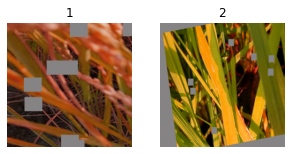

In [ ]:
dl = RiceDataModule(train, train, test, test, config)
dl = dl.train_dataloader()
batch_rgb, batch_rgn = dl['rgb'], dl['rgn']
batch = next(iter(batch_rgb))
imgs1, classes1 = batch['image'], batch['target']

std = np.array([0.229, 0.224, 0.225])
mean = np.array([0.485, 0.456, 0.406])
plt.figure(figsize=(16,16))
for i,(img, cls) in enumerate(zip(imgs1, classes1)):
    img = ((img.permute(1,2,0)*std + mean)*255.0).numpy().astype(np.uint8)
    plt.subplot(6,6,i+1)
    plt.imshow(img,)
    plt.title(f'{cls.data:.0f}')
    plt.axis('off')
    plt.subplots_adjust(wspace=None, hspace=None)

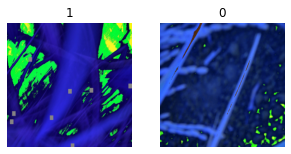

In [ ]:
batch = next(iter(batch_rgn))
imgs, classes = batch['image'], batch['target']

plt.figure(figsize=(16,16))
for i,(img, cls) in enumerate(zip(imgs, classes)):
    img = ((img.permute(1,2,0)*std + mean)*255.0).numpy().astype(np.uint8)
    plt.subplot(6,6,i+1)
    plt.imshow(img,)
    plt.title(f'{cls.data:.0f}')
    plt.axis('off')
    plt.subplots_adjust(wspace=None, hspace=None)

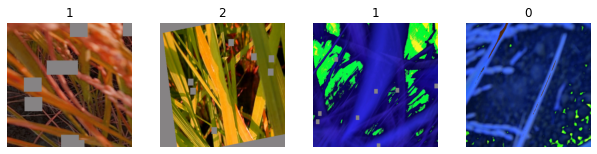

In [ ]:
xx = torch.cat((imgs1, imgs), 0)
yy = torch.cat((classes1, classes))
plt.figure(figsize=(16,16))
for i,(img, cls) in enumerate(zip(xx, yy)):
    img = ((img.permute(1,2,0)*std + mean)*255.0).numpy().astype(np.uint8)
    plt.subplot(6,6,i+1)
    plt.imshow(img,)
    plt.title(f'{cls.data:.0f}')
    plt.axis('off')
    plt.subplots_adjust(wspace=None, hspace=None)

In [ ]:
def mixup(x: torch.Tensor, y: torch.Tensor, alpha: float = 1.0):
    assert alpha > 0, "alpha should be larger than 0"
    assert x.size(0) > 1, "Mixup cannot be applied to a single instance."

    lam = np.random.beta(alpha, alpha)
    rand_index = torch.randperm(x.size()[0])
    mixed_x = lam * x + (1 - lam) * x[rand_index, :]
    target_a, target_b = y, y[rand_index]
    return mixed_x, target_a, target_b, lam

In [ ]:
class RiceModule(pl.LightningModule):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg
        self.__build_model()
        self.train_acc = torchmetrics.Accuracy()
        self.val_acc = torchmetrics.Accuracy()
        self.save_hyperparameters(cfg)
        self.criteria = torch.nn.CrossEntropyLoss()
  
    def __build_model(self):
        self.n_classes = Config.NUM_CLASSES
        self.backbone = create_model(self.cfg.model.name, pretrained=True, num_classes=0, in_chans=3)
        in_features = self.backbone.num_features
        self.fc = nn.Sequential(nn.Dropout(0.5), nn.Linear(in_features, Config.NUM_CLASSES))
        
    def forward(self, x):
        f = self.backbone(x)
        out = self.fc(f)
        return out
    
    def training_step(self, batch, batch_idx):
        loss, pred, labels = self.__share_step(batch, 'train')
        acc = self.train_acc(pred, labels)
        self.log(name="train_metric",value=loss,prog_bar=True,on_epoch=True, on_step=False,sync_dist=True,rank_zero_only=True,)
        self.log(name="train_acc",value=acc,prog_bar=True,on_epoch=True, on_step=False,sync_dist=True,rank_zero_only=True,)
        return {'loss': loss, 'pred': pred, 'labels': labels}
        
    def validation_step(self, batch, batch_idx, dataloader_idx = 0):
        loss, pred, labels = self.__share_step(batch, 'val')
        acc = self.val_acc(pred, labels)
        self.log(name="val_metric",value=loss,prog_bar=True,on_epoch=True, on_step=False,sync_dist=True,rank_zero_only=True,)
        self.log(name="val_acc",value=acc,prog_bar=True,on_epoch=True, on_step=False,sync_dist=True,rank_zero_only=True)
        return {'loss': loss, 'pred': pred, 'labels': labels}

    def validation_step(self, batch, batch_idx, dataloader_idx = 1):
        loss, pred, labels = self.__share_step(batch, 'val')
        acc = self.val_acc(pred, labels)
        self.log(name="val_metric",value=loss,prog_bar=True,on_epoch=True, on_step=False,sync_dist=True,rank_zero_only=True,)
        self.log(name="val_acc",value=acc,prog_bar=True,on_epoch=True, on_step=False,sync_dist=True,rank_zero_only=True)
        return {'loss': loss, 'pred': pred, 'labels': labels}

    def validation_step(self, batch, batch_idx, dataloader_idx = 2):
        loss, pred, labels = self.__share_step(batch, 'val')
        acc = self.val_acc(pred, labels)
        self.log(name="val_metric",value=loss,prog_bar=True,on_epoch=True, on_step=False,sync_dist=True,rank_zero_only=True,)
        self.log(name="val_acc",value=acc,prog_bar=True,on_epoch=True, on_step=False,sync_dist=True,rank_zero_only=True)
        return {'loss': loss, 'pred': pred, 'labels': labels}
    
    def __share_step(self, batch, mode, dataloader_idx: int = None):
        if mode == 'train':
          batch_rgb, batch_rgn = batch['rgb'], batch['rgn']
          images_rgb, labels_rgb, images_rgn, labels_rgn = batch_rgb['image'], batch_rgb['target'], batch_rgn['image'], batch_rgn['target']
          labels_rgb, labels_rgn = labels_rgb.to(torch.long), labels_rgn.to(torch.long)
          images, labels = torch.cat((images_rgb, images_rgn), 0), torch.cat((labels_rgb, labels_rgn))
          labels = labels.to(torch.long)

          if torch.rand(1)[0] < 0.5:
              mix_images, target_a, target_b, lam = mixup(images, labels, alpha=0.5)
              logits = self.forward(mix_images).squeeze(1)
              loss = self.criteria(logits, target_a) * lam + (1 - lam) * self.criteria(logits, target_b)
          else:
            logits = self.forward(images).squeeze(1)
            loss = self.criteria(logits, labels)
          
          pred = logits.sigmoid().detach().cpu()
          labels = labels.detach().cpu()
          del images, batch
          return loss, pred, labels

        elif mode == 'val':
          images, labels = batch['image'], batch['target']
          logits = self.forward(images).squeeze(1)
          loss = self.criteria(logits, labels)

          pred = logits.sigmoid().detach().cpu()
          labels = labels.detach().cpu()
          del images, batch
          return loss, pred, labels

    def test_step(self, batch, batch_idx, dataloader_idx = 0):
        preds = self.model(batch['image'])
        return {'preds': preds}

    def test_step(self, batch, batch_idx, dataloader_idx = 1):
        preds = self.model(batch['image'])
        return {'preds': preds}
    
    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        preds = self(batch['image'].to(torch.float))
        return preds

    def predict_step(self, batch, batch_idx, dataloader_idx=1):
        preds = self(batch['image'].to(torch.float))
        return preds

    def test_epoch_end(self, outputs):
        outputs1, outputs2 = outputs[0], outputs[1]
        preds_rgb = torch.cat([x['preds'] for x in outputs1])
        preds_rgn = torch.cat([x['preds'] for x in outputs2])
        return preds_rgb, preds_rgn
    
    def configure_optimizers(self):
        optimizer = eval(self.cfg.optimizer.name)(self.parameters(), **self.cfg.optimizer.params)
        scheduler = eval(self.cfg.scheduler.name)(optimizer,**self.cfg.scheduler.params)
        return [optimizer], [scheduler]

In [ ]:
def predict_and_save(dl, path):
  preds = trainer.predict(dataloaders=dl)
  preds = softmax(torch.cat(preds[0]).squeeze(-1).cpu().detach().numpy(), axis=-1)
  preds_df = pd.DataFrame(preds)
  preds_df.columns = [inv_mapper[c] for c in preds_df.columns]
  preds_df = preds_df[ss.columns[1:]]
  preds_df.insert(0, Config.ID_COL, test[test.pic_type == 'RGB'].Image_id.values)
  preds_df.to_csv(path, index = False)
  return preds_df

# Create checkpoint directories
VERSION_OUTPUT_PATH = Config.OUTPUT_PATH + os.sep + Config.NAME
Path(VERSION_OUTPUT_PATH).mkdir(parents=True, exist_ok=True)

MODEL_SAVE_PATH = 'model_checkpoints' + os.sep + Config.NAME
Path(MODEL_SAVE_PATH).mkdir(parents=True, exist_ok=True)

In [ ]:
train_rgb = train[train.pic_type == 'RGB'].reset_index(drop = True)
train_rgn = train[train.pic_type == 'RGN'].reset_index(drop = True)
test_rgb = test[test.pic_type == 'RGB'].reset_index(drop = True)
test_rgn = test[test.pic_type == 'RGN'].reset_index(drop = True)
train_rgb['fold'], train_rgn['fold'] = 0, 0

skf = StratifiedKFold(n_splits=Config.N_SPLITS, shuffle=True, random_state=config.seed)
for fold, (train_idx, val_idx) in enumerate(skf.split(train_rgb.image_path, train_rgb.mapped_label)):
  train_rgb.loc[val_idx, 'fold'] = fold
  train_rgn.loc[val_idx, 'fold'] = fold

train_df = pd.concat([train_rgb, train_rgn], ignore_index = True)

In [ ]:
oof_test_preds = []
for fold, max_epochs in zip(range(1), [31]):
  train_dff = train_df[train_df.fold != fold].reset_index(drop = True)
  val_dff = train_df[train_df.fold == fold].reset_index(drop = True)
  val_dff_rgb = val_dff[val_dff.pic_type == 'RGB'].reset_index(drop = True)
  val_dff_rgn = val_dff[val_dff.pic_type == 'RGN'].reset_index(drop = True)

  config.trainer.max_epochs = max_epochs
  datamodule = RiceDataModule(train_dff, val_dff, test, val_dff, config)

  model = RiceModule(config)

  lr_monitor = pl.callbacks.LearningRateMonitor()

  loss_checkpoint = pl.callbacks.ModelCheckpoint(
            dirpath=MODEL_SAVE_PATH+os.sep+str(fold),
            save_weights_only = True,
            filename='model-{epoch}-{val_metric:.4f}-{val_loss:.4f}')

  logger = pl.loggers.WandbLogger(project=Config.PROJECT_NAME, name = f'fold_{fold}')

  swa_callback = pl.callbacks.StochasticWeightAveraging(swa_epoch_start=2)

  trainer = pl.Trainer(
            logger=logger,
            callbacks=[lr_monitor, loss_checkpoint],
            **config.trainer)

  trainer.fit(model, datamodule=datamodule)

  path = VERSION_OUTPUT_PATH + os.sep + f'test_preds_fold_{fold}.csv'
  preds_df = predict_and_save(datamodule.test_dataloader(), path)
  oof_test_preds.append(preds_df)
  wandb.save(path)
 
  _ = datamodule.teardown()

  del model, trainer, datamodule, train_dff, val_dff
  _ = gc.collect()
  _ = torch.cuda.empty_cache()
  _ = gc.collect()

  wandb.finish()

Downloading: "https://github.com/SwinTransformer/storage/releases/download/v2.0.0/swinv2_large_patch4_window12to24_192to384_22kto1k_ft.pth" to /root/.cache/torch/hub/checkpoints/swinv2_large_patch4_window12to24_192to384_22kto1k_ft.pth
wandb: Currently logged in as: plato96. Use `wandb login --relogin` to force relogin


INFO:pytorch_lightning.trainer.connectors.accelerator_connector:Auto select gpus: [0]
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit apex Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True, used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type              | Params
------------------------------------------------
0 | backbone  | SwinTransformerV2 | 195 M 
1 | fc        | Sequential        | 4.6 K 
2 | train_acc | Accuracy          | 0     
3 | val_acc   | Accuracy          | 0     
4 | criteria  | CrossEntropyLoss  | 0     
------------------------------------------------
195 M     Trainable

Selected optimization level O2:  FP16 training with FP32 batchnorm and FP32 master weights.

Defaults for this optimization level are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic


Training: 0it [00:00, ?it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0


Validation: 0it [00:00, ?it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0


Validation: 0it [00:00, ?it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2048.0


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0


Validation: 0it [00:00, ?it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0


Validation: 0it [00:00, ?it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/model_checkpoints/swinV2/0/model-epoch=30-val_metric=0.0000-val_loss=0.0000.ckpt
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from checkpoint at /content/model_checkpoints/swinV2/0/model-epoch=30-val_metric=0.0000-val_loss=0.0000.ckpt


Predicting: 1201it [00:00, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
lr-AdamW,▁▁▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▆▆▆▇▇██
train_acc,▁▄▅▆▆▆▇▇▇▇█▇█▇▇█▇▇████████████▇
train_metric,█▅▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
val_acc/dataloader_idx_0,▁▅▄▅█▆▆▇▆▆▇▇▆▇▂▆▇▆▆▆▆█▇██▇▆▇▆██
val_acc/dataloader_idx_1,▁▄▅▂▃▆▆▆▇▇▅▇▆▇█▇▇█▇█▇█▇▇█▇▇▇█▇█
val_acc/dataloader_idx_2,▁▅▄▅█▆▆▇▆▆▇▇▆▇▂▆▇▆▆▆▆█▇██▇▆▇▆██
val_metric/dataloader_idx_0,▆▃▃▄▂▂▂▂▂▃▂▂▃▂█▃▃▄▃▃▅▂▂▁▁▂▃▂▂▂▁
val_metric/dataloader_idx_1,█▅▄▆▆▃▂▂▂▂▄▂▄▂▁▂▂▂▂▁▂▂▂▂▂▁▂▃▁▃▁
val_metric/dataloader_idx_2,▆▃▃▄▂▂▂▂▂▃▂▂▃▂█▃▃▄▃▃▅▂▂▁▁▂▃▂▂▂▁


In [ ]:
# Pseudo labeling 
pseudo = oof_test_preds[0].copy()
pseudo['prediction'] = pseudo.iloc[:, 1:].idxmax(axis = 1)
pseudo['max_probability'] = pseudo.iloc[:, 1:4].max(axis = 1)

# Psudo label any prediction which is >=0.999
pseudo = pseudo[pseudo.max_probability >= 0.999]

# After different experimentations and probability analysis add the following to the pseudo labels
prob_analysis = pd.Series({'id_7troz2ms9w.jpg': 1,
  'id_wnlql3t1c1.jpg': 2,
  'id_xg82bhcs72.jpg': 0,
  'id_37dlaohacg.jpg': 0,
  'id_5nkfatffwe.jpg': 2,
  'id_ioeltwwdfm.jpg': 2,
  'id_wrukk3s51z.jpg': 1,
  'id_wq18wcp81e.jpg': 0,
  'id_0r2hdgahag.jpg': 0,
  'id_blx62wltrk.jpg': 1}).to_frame().reset_index()

prob_analysis.columns = ['Image_id', 'prediction']
prob_analysis.prediction = prob_analysis.prediction.map(inv_mapper)
pseudo = pd.concat([pseudo, prob_analysis])
pseudo['mapped_label'] = pseudo.prediction.map(mapper)
pseudo['image_path'] = ['Images/'+ x for x in pseudo.Image_id]
pseudo.head()

,Image_id,blast,brown,healthy,prediction,max_probability,mapped_label,image_path
0,id_00vl5wvxq3.jpg,0.999701,0.000160,0.000139,blast,0.999701,0,Images/id_00vl5wvxq3.jpg
1,id_01hu05mtch.jpg,0.000695,0.999253,0.000052,brown,0.999253,1,Images/id_01hu05mtch.jpg
3,id_03z57m8xht.jpg,0.999746,0.000150,0.000104,blast,0.999746,0,Images/id_03z57m8xht.jpg
4,id_04ngep1w4b.jpg,0.999714,0.000074,0.000212,blast,0.999714,0,Images/id_04ngep1w4b.jpg
5,id_050c6jzczt.jpg,0.000438,0.999321,0.000241,brown,0.999321,1,Images/id_050c6jzczt.jpg


In [ ]:
!pip install -qq fastai -U
from fastai.vision.all import *

In [ ]:
# Retrain with more data/pseudos
set_seed(config.seed, True)
fold = 0
train_dff = train_df[train_df.pic_type == 'RGB'].reset_index(drop = True)
train_dff.loc[train_dff[train_dff.fold != fold].index, 'is_valid'] = False
train_dff.loc[train_dff[train_dff.fold == fold].index, 'is_valid'] = True
pseudo['is_valid'] = False
train_dff = pd.concat([train_dff, pseudo])

dls = ImageDataLoaders.from_df(train_dff, fn_col='Image_id', label_col='mapped_label', seed= config.seed, bs=16, valid_col="is_valid",
                              folder='Images', item_tfms=Resize(400), batch_tfms = aug_transforms(size=192, min_scale=0.75))

learn = vision_learner(dls, 'swinv2_large_window12_192_22k', metrics=error_rate).to_fp16()
learn.fine_tune(25, 0.001)
test_preds, _ = learn.get_preds(dl=dls.test_dl(test_rgb)) 

# Prepare sub file
submission = pd.DataFrame({'Image_id': test_rgb['Image_id']})
for i, label in enumerate(learn.dls.vocab):
  submission[label] = test_preds[:,i].numpy()
submission.columns = ['Image_id', 'blast',	'brown',	'healthy']
submission.to_csv('final_submission.csv', index = False)

Downloading: "https://github.com/SwinTransformer/storage/releases/download/v2.0.0/swinv2_large_patch4_window12_192_22k.pth" to /root/.cache/torch/hub/checkpoints/swinv2_large_patch4_window12_192_22k.pth


epoch,train_loss,valid_loss,error_rate,time
0,0.760518,0.381830,0.138577,00:38


epoch,train_loss,valid_loss,error_rate,time
0,0.454671,0.266518,0.097378,00:55
1,0.409404,0.239000,0.082397,00:55
2,0.338528,0.228702,0.078652,00:55
3,0.257894,0.249712,0.067416,00:55
4,0.241338,0.207039,0.052434,00:55
5,0.221003,0.175032,0.044944,00:55
6,0.222447,0.164850,0.037453,00:55
7,0.152967,0.247492,0.056180,00:55
8,0.149107,0.174239,0.044944,00:55
9,0.112207,0.201912,0.041199,00:55


In [ ]:
submission.head()

,Image_id,blast,brown,healthy
0,id_00vl5wvxq3.jpg,0.999997,1.158978e-06,0.000002
1,id_01hu05mtch.jpg,0.000389,9.993761e-01,0.000235
2,id_030ln10ewn.jpg,0.498025,5.019313e-01,0.000044
3,id_03z57m8xht.jpg,0.999984,8.852759e-06,0.000007
4,id_04ngep1w4b.jpg,0.999996,3.569367e-07,0.000004
